In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['embeddings', 'train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')


#train_char = pd.read_csv('../input/train.csv')
#test_char = pd.read_csv('../input/test.csv')

In [3]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
from collections import defaultdict
from nltk.corpus import stopwords
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

stop_words = set(stopwords.words('english')) 
insinc_df = train[train.target==1]
sinc_df = train[train.target==0]

def plot_ngrams(n_grams):

    ## custom function for ngram generation ##
    def generate_ngrams(text, n_gram=1):
        token = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
        ngrams = zip(*[token[i:] for i in range(n_gram)])
        return [" ".join(ngram) for ngram in ngrams]

    ## custom function for horizontal bar chart ##
    def horizontal_bar_chart(df, color):
        trace = go.Bar(
            y=df["word"].values[::-1],
            x=df["wordcount"].values[::-1],
            showlegend=False,
            orientation = 'h',
            marker=dict(
                color=color,
            ),
        )
        return trace

    def get_bar(df, bar_color):
        freq_dict = defaultdict(int)
        for sent in df["question_text"]:
            for word in generate_ngrams(sent, n_grams):
                freq_dict[word] += 1
        fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
        fd_sorted.columns = ["word", "wordcount"]
        trace = horizontal_bar_chart(fd_sorted.head(10), bar_color)
        return trace    

    trace0 = get_bar(sinc_df, 'blue')
    trace1 = get_bar(insinc_df, 'blue')

    # Creating two subplots
    if n_grams == 1:
        wrd = "words"
    elif n_grams == 2:
        wrd = "bigrams"
    elif n_grams == 3:
        wrd = "trigrams"
    
    fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                              subplot_titles=["Frequent " + wrd + " of sincere questions", 
                                              "Frequent " + wrd + " of insincere questions"])
    fig.append_trace(trace0, 1, 1)
    fig.append_trace(trace1, 1, 2)
    fig['layout'].update(height=500, width=1150, paper_bgcolor='rgb(233,233,233)', title=wrd + " Count Plots")
    py.iplot(fig, filename='word-plots')

In [5]:
plot_ngrams(1)

/opt/conda/lib/python3.6/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [6]:
plot_ngrams(2)

In [7]:
plot_ngrams(3)

In [8]:
#######################
#EDA for training Data#
#######################

t1 = train[["target"]]
def score_to_numeric(x):
    if x==0:
        return "Sincere"
    if x==1:
        return "Insincere"
t1['target_class'] = t1['target'].apply(score_to_numeric)
t1_1 = t1.groupby(['target_class']).count()
t1_1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,target
target_class,
Insincere,80810
Sincere,1225312


In [9]:
########################
#number of group target#
########################

import plotly.graph_objects as go
fig = go.Figure(go.Bar(
            x=[80810, 1225312],
            y=['Insincere', 'Sincere'],
            orientation='h',
    marker=dict(
        color='rgba(51, 204, 204, 0.6)',
        line=dict(color='rgba(58, 71, 80, 1.0)', width=3))))

fig.show()

In [10]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
####################################
#number of character in each target#
####################################
t2 = train[["question_text", "target"]]
def score_to_numeric(x):
    if x==0:
        return "Sincere"
    if x==1:
        return "Insincere"
t2['target_class'] = t2['target'].apply(score_to_numeric)
t2_1 = t2[['question_text', 'target_class']]
t2_1.head()

,question_text,target_class
0,How did Quebec nationalists see their province...,Sincere
1,"Do you have an adopted dog, how would you enco...",Sincere
2,Why does velocity affect time? Does velocity a...,Sincere
3,How did Otto von Guericke used the Magdeburg h...,Sincere
4,Can I convert montra helicon D to a mountain b...,Sincere


In [11]:
def tokenize_character(text):
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = text.lower()   
    text = re.sub(r'\b(?:(?:https?|ftp)://)?\w[\w-]*(?:\.[\w-]+)+\S*', ' ', text) # remove hyperlink,subs charact in the brackets
    text = re.sub("[\r\n]", ' ', text) # remove new line characters
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if re.match(r'.*[a-z]{2,}.*', token)]
    return tokens

#t2_1["tokens"] = t2_1['question_text'].map(lambda x: tokenize_character(x))
t2_1["tokens"] = t2_1['question_text'].apply(tokenize_character) 
t2_1["word_count"] = t2_1.tokens.apply(lambda x: len(x))
t2_1.tail()

,question_text,target_class,tokens,word_count
1306117,What other technical skills do you need as a c...,Sincere,"[what, other, technical, skills, do, you, need...",14
1306118,Does MS in ECE have good job prospects in USA ...,Sincere,"[does, ms, in, ece, have, good, job, prospects...",19
1306119,Is foam insulation toxic?,Sincere,"[is, foam, insulation, toxic]",4
1306120,How can one start a research project based on ...,Sincere,"[how, can, one, start, research, project, base...",12
1306121,Who wins in a battle between a Wolverine and a...,Sincere,"[who, wins, in, battle, between, wolverine, an...",8


In [12]:
t2_2 = t2_1[["target_class", "word_count"]]
t2_2.head()

,target_class,word_count
0,Sincere,11
1,Sincere,16
2,Sincere,10
3,Sincere,9
4,Sincere,12


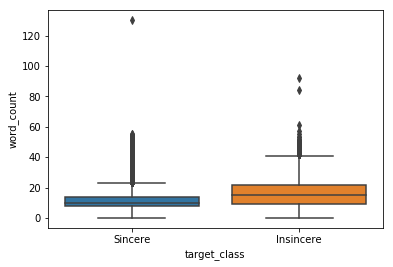

In [13]:
# library & dataset
import seaborn as sns
#df = sns.load_dataset('iris')
sns.boxplot(x=t2_2["target_class"], y=t2_2["word_count"])
#sns.plt.show()